변경 내용
- optimizer: `AdamW`

In [39]:
# Formatted with Black
# !pip install black[jupyter]
# !black /content/drive/MyDrive/Capstone/tdcn-test.ipynb

# TDCN 이미지 예측 모델 구현

In [40]:
import os
import warnings
from collections import Counter
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix

In [41]:
drive.mount("/content/drive")
warnings.simplefilter("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 80
LEARNING_RATE = 2e-5
CWD = "/content/drive/MyDrive/Capstone"


def join_path(*args):
    return os.path.join(CWD, *args)


TRAIN_CSV = [
    join_path("data", csv)
    for csv in ["feat_xtrain.csv", "pose_xtrain.csv", "ytrain.csv"]
]
TEST_CSV = [
    join_path("data", csv) for csv in ["feat_xtest.csv", "pose_xtest.csv", "ytest.csv"]
]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

In [42]:
class CustomDataset(Dataset):
    def __init__(self, x1_file, x2_file, y_file, mode=None):
        x1_df = pd.read_csv(x1_file)  # landmark data
        x2_df = pd.read_csv(x2_file)  # pose data
        y_df = pd.read_csv(y_file)

        x1 = x1_df.values
        x2 = x2_df.values
        if mode == "train":
            y = y_df.iloc[:, 1].values
        else:
            y = y_df.values

        self.x1_data = torch.FloatTensor(x1)
        self.x2_data = torch.FloatTensor(x2)
        self.y_data = torch.IntTensor(y)

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, index):
        return (
            self.x1_data[index * 5000 : (index + 1) * 5000],
            self.x2_data[index * 5000 : (index + 1) * 5000],
        ), self.y_data[index]

In [43]:
# 데이터셋
training_data = CustomDataset(*TRAIN_CSV, mode="train")
test_data = CustomDataset(*TEST_CSV)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

# Dilated Conv Block

In [44]:
class DilatedConvBlock(nn.Module):
    def __init__(self, has_BN=False, batch_size=8):
        super(DilatedConvBlock, self).__init__()
        self._c = 1
        self._has_BN = has_BN

        self.dilated_conv1 = self.dilated_conv(1)
        self.dilated_conv2 = self.dilated_conv(2)
        self.dilated_conv3 = self.dilated_conv(4)
        self.conv1d = nn.Conv2d(self._c, self._c, kernel_size=(1, 1))
        self.BN = nn.BatchNorm2d(self._c, affine=True)

    def dilated_conv(self, d):
        return nn.Conv2d(
            self._c,
            self._c,
            kernel_size=(3, 3),
            stride=1,
            padding="same",
            dilation=d,
            bias=True,
            padding_mode="zeros",
        )

    def forward(self, x):
        x_1d = self.conv1d(x)

        # DCN with d=1
        x_2d_1 = self.dilated_conv1(x)
        x_2d_2 = self.dilated_conv1(x)
        x_2d = x_2d_1 + x_2d_2
        x_2d = F.elu(x_2d)

        # DCN with d=2
        x_2d_1 = self.dilated_conv2(x_2d)
        x_2d_2 = self.dilated_conv2(x_2d)
        x_2d = x_2d_1 + x_2d_2
        x_2d = F.elu(x_2d)

        # DCN with d=4
        x_2d_1 = self.dilated_conv3(x_2d)
        x_2d_2 = self.dilated_conv3(x_2d)
        x_2d = x_2d_1 + x_2d_2
        x_2d = F.elu(x_2d)

        x = x_2d_1 + x_2d_2
        
        if self._has_BN:
            x = self.BN(x)
        return x

# TDCN + FWA + Prediction

In [46]:
class PredictionModel(nn.Module):
    def __init__(self, batch_size=8):
        super(PredictionModel, self).__init__()

        self.TDCN = nn.Sequential(
            DilatedConvBlock(has_BN=True, batch_size=BATCH_SIZE),
            nn.MaxPool2d(kernel_size=(2, 1), stride=None),
            DilatedConvBlock(has_BN=True, batch_size=BATCH_SIZE),
            nn.MaxPool2d(kernel_size=(2, 1), stride=None),
            DilatedConvBlock(has_BN=True, batch_size=BATCH_SIZE),
            nn.MaxPool2d(kernel_size=(2, 1), stride=None),
            DilatedConvBlock(has_BN=True, batch_size=BATCH_SIZE),
            nn.MaxPool2d(kernel_size=(2, 1), stride=None),
            DilatedConvBlock(has_BN=False),
        )
        self.classify = nn.Sequential(
            nn.Linear(142, 64), nn.Linear(64, 32), nn.Linear(32, 2), nn.Softmax(dim=3)
        )

        self.attention_layer = nn.Sequential(
            nn.Linear(142, 142),
            nn.ReLU(inplace=True),
            nn.Linear(142, 142),
            nn.Sigmoid(),
        )

    def global_average_pooling(self, x):
        return torch.mean(x, dim=2)

    def FWA(self, x1, x2):
        x = torch.concat((x1, x2), dim=3)

        x_ = self.global_average_pooling(x)
        x_ = self.attention_layer(x_)
        x_ = torch.unsqueeze(x_, 2)
        x = torch.mul(x, x_)

        return x

    def forward(self, x_landmark, x_pose):
        x_landmark = self.TDCN(x_landmark)
        x_pose = self.TDCN(x_pose)
        x = self.FWA(x_landmark, x_pose)
        score = self.classify(x)
        score = score[:, :, :, 0].mean(dim=2)
        return score

# Train

In [47]:
loss_fn = nn.BCELoss()
model = PredictionModel().to(device)
optimizer = AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=5e-3
)
scheduler = LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)

In [48]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        x1, x2 = X
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y = y.to(torch.float32)
        pred = model(
            x1.unsqueeze(0).permute(1, 0, 2, 3), x2.unsqueeze(0).permute(1, 0, 2, 3)
        )
        loss = loss_fn(pred, y.unsqueeze(1))

        optimizer.zero_grad()
        loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
    loss = loss.item()
    return loss


def test(dataloader, model, loss_fn, return_metrics=False):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    real_values = torch.IntTensor().to(device)
    pred_values = torch.IntTensor().to(device)

    with torch.no_grad():
        for X, y in dataloader:
            x1, x2 = X
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            y = torch.Tensor(y)
            pred = model(
                x1.unsqueeze(0).permute(1, 0, 2, 3), x2.unsqueeze(0).permute(1, 0, 2, 3)
            )

            test_loss += loss_fn(pred, y.to(torch.float32)).item()

            if return_metrics:
                real_values = torch.cat((real_values, y), dim=0)
                pred_values = torch.cat(
                    (pred_values, torch.round(pred).to(torch.int32)), dim=0
                )

    if not return_metrics:
        # 학습 과정에서는 Loss 값만 확인합니다.
        test_loss /= num_batches
        return test_loss

    else:
        # 학습이 종료되고 성능 평가 지표를 확인합니다. 
        real_values = real_values.squeeze().cpu().detach().numpy()
        pred_values = pred_values.squeeze().cpu().detach().numpy()

        accuracy = accuracy_score(real_values, pred_values)
        f1 = f1_score(real_values, pred_values)
        f1_macro = f1_score(real_values, pred_values, average="macro")
        recall = recall_score(real_values, pred_values)
        precision = precision_score(real_values, pred_values)
        matrix = confusion_matrix(real_values, pred_values).ravel()

        return {
            "matrix": matrix,
            "accuracy": accuracy,
            "f1": f1,
            "f1-macro": f1_macro,
            "recall": recall,
            "precision": precision
        }
    

In [49]:
epoch_progress = trange(1, EPOCHS + 1)
tqdm.write("\nEpoch | Train Loss | Test Loss")
tqdm.write("-" * 30)

for epoch in epoch_progress:
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    scheduler.step()
    if epoch % 5 == 0:
        tqdm.write(
            f"{epoch:5} | {train_loss:10.5f} | {test_loss:9.5f}"
        )

  0%|          | 0/80 [00:00<?, ?it/s]


Epoch | Train Loss | Test Loss
------------------------------
    5 |    0.50252 |   0.61052
   10 |    0.46394 |   0.59767
   15 |    0.44292 |   0.59137
   20 |    0.43065 |   0.58794
   25 |    0.42305 |   0.58592
   30 |    0.41810 |   0.58465
   35 |    0.41475 |   0.58381
   40 |    0.41241 |   0.58324
   45 |    0.41074 |   0.58283
   50 |    0.40953 |   0.58254
   55 |    0.40863 |   0.58232
   60 |    0.40796 |   0.58216
   65 |    0.40746 |   0.58204
   70 |    0.40708 |   0.58195
   75 |    0.40679 |   0.58188
   80 |    0.40657 |   0.58183


In [56]:
torch.save(model.state_dict(), join_path("tdcn-adam.pth"))
torch.cuda.empty_cache()

# Evaluation

In [57]:
metrics = test(test_dataloader, model, loss_fn, return_metrics=True)

print(f"Accuracy:  {metrics['accuracy']:.3f}")
print(f"F1-score:  {metrics['f1']:.3f}")
print(f"F1-macro:  {metrics['f1-macro']:.3f}")
print(f"Recall:    {metrics['recall']:.3f}")
print(f"Precision: {metrics['precision']:.3f}")

print("-" * 30)
tn, fp, fn, tp = metrics["matrix"]
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn}")
print(f"TP: {tp}")

Accuracy:  0.702
F1-score:  0.000
F1-macro:  0.412
Recall:    0.000
Precision: 0.000
------------------------------
TN: 33
FP: 0
FN: 14
TP: 0


# Testset Distribution

In [58]:
test_csv = pd.read_csv(join_path("data", "ytest.csv"))
test_csv.head()

,PHQ_Binary
0,0
1,0
2,0
3,1
4,1


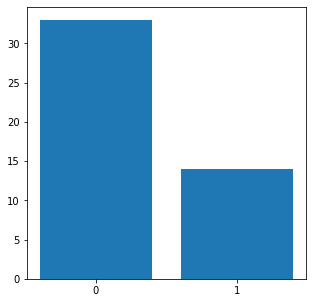

In [59]:
labels = test_csv["PHQ_Binary"].tolist()
num_labels = Counter(labels)

plt.figure(figsize=(5, 5))
plt.bar(["0", "1"], [num_labels[0], num_labels[1]])
plt.show()